In [16]:
from optimisation_models.battery_optimisation import OptimisationParameters
from optimisation_models.battery_without_rh_model import DataPreparation
from optimisation_models.project_cost_calculation import ProjectCost
import numpy as np
import matplotlib.pyplot as plt

In [2]:
price_type = 'dispatch'
dispatch_price_file = 'data/prices/RRP_NSW1_half_hourly_2021.csv'
prosumer_binding_file = 'data/processed/prosumer_rho/aggregate_data/aggregate_0_lookahead_pd_price.csv'
data_preparation = DataPreparation(prosumer_binding_file, price_type=price_type, dispatch_price_file=dispatch_price_file)
df_prosumer_agg_binding = data_preparation.read_prosumer_binding_data()
battery_opti_params = OptimisationParameters(df_prosumer_agg_binding)

In [3]:
project_cost = ProjectCost(battery_opti_params, df_prosumer_agg_binding)

## Show ground truth cost for different capacity from rho model

In [4]:
rho_model_folder = 'data/processed/battery/rho_model'
battery_capacity_list = [230, 235, 240, 245, 250, 255, 260, 265, 270, 320, 325, 350, 468, 486]

In [9]:
# Base case for 250 kWh battery
battery_capacity = 250
battery_file_name = rho_model_folder + f'/battery_{battery_capacity}_rho_model.csv'
df_battery_rho_model = project_cost.get_battery_data(battery_file_name)
cost_information = project_cost.get_project_cost(df_battery_rho_model)
base_cost = cost_information['ground_truth_cost']

for battery_capacity in battery_capacity_list:
    battery_file_name = rho_model_folder + f'/battery_{battery_capacity}_rho_model.csv'
    df_battery_rho_model = project_cost.get_battery_data(battery_file_name)
    cost_information = project_cost.get_project_cost(df_battery_rho_model)

    cost = cost_information['ground_truth_cost']
    energy_charge = cost_information['energy_charge']
    peak_reduction = cost_information['peak_reduction']
    peak_saving = cost_information['peak_saving']

    loss = 100 * (cost - base_cost) / base_cost
    print(f'battery {battery_capacity} - cost: {cost} - % loss: {loss:.2f} - energy charge: {energy_charge} - peak reduction: {peak_reduction} - peak saving: {peak_saving}')

battery 230 - cost: 48478.8 - % loss: 1.98 - energy charge: 40553.79 - peak reduction: -114.14 - peak saving: -13792.73
battery 235 - cost: 48312.57 - % loss: 1.63 - energy charge: 39953.19 - peak reduction: -114.14 - peak saving: -13792.73
battery 240 - cost: 47756.85 - % loss: 0.46 - energy charge: 38951.82 - peak reduction: -114.14 - peak saving: -13792.73
battery 245 - cost: 47656.06 - % loss: 0.25 - energy charge: 38407.64 - peak reduction: -114.14 - peak saving: -13792.73
battery 250 - cost: 47537.58 - % loss: 0.00 - energy charge: 37828.7 - peak reduction: -114.14 - peak saving: -13792.73
battery 255 - cost: 47682.89 - % loss: 0.31 - energy charge: 37518.39 - peak reduction: -114.14 - peak saving: -13792.73
battery 260 - cost: 47986.76 - % loss: 0.94 - energy charge: 37377.63 - peak reduction: -114.14 - peak saving: -13792.73
battery 265 - cost: 48253.94 - % loss: 1.51 - energy charge: 37195.68 - peak reduction: -114.14 - peak saving: -13792.73
battery 270 - cost: 48601.51 - % l

## Compare results between perfect foresight and RHO

In [21]:
without_rh_model_file = 'data/processed/battery/without_rh_sizing/battery_320_dispatch_without_rh_sizing.csv'
df_battery_without_rh = project_cost.get_battery_data(without_rh_model_file)

In [22]:
cost_information = project_cost.get_project_cost(df_battery_without_rh)
# Divide by 1000 to convert to k$
perfect_foresight_luos = cost_information['dnsp_charge'] / 1000
perfect_foresight_grid_payment = cost_information['energy_charge'] / 1000
perfect_foresight_battery_opex = cost_information['battery_opex'] / 1000
perfect_foresight_battery_cost = cost_information['battery_cost'] / 1000
perfect_foresight_peak_reduction = cost_information['peak_saving'] / 1000
perfect_foresight_total_cost = cost_information['ground_truth_cost'] / 1000

In [23]:
rho_model_file = 'data/processed/battery/rho_model/battery_320_rho_model.csv'
df_battery_rho_model = project_cost.get_battery_data(rho_model_file)

In [24]:
cost_information = project_cost.get_project_cost(df_battery_rho_model)
# Divide by 1000 to convert to k$
rho_luos = cost_information['dnsp_charge'] / 1000
rho_grid_payment = cost_information['energy_charge'] / 1000
rho_battery_opex = cost_information['battery_opex'] / 1000
rho_battery_cost = cost_information['battery_cost'] / 1000
rho_peak_reduction = cost_information['peak_saving'] / 1000
rho_total_cost = cost_information['ground_truth_cost'] / 1000

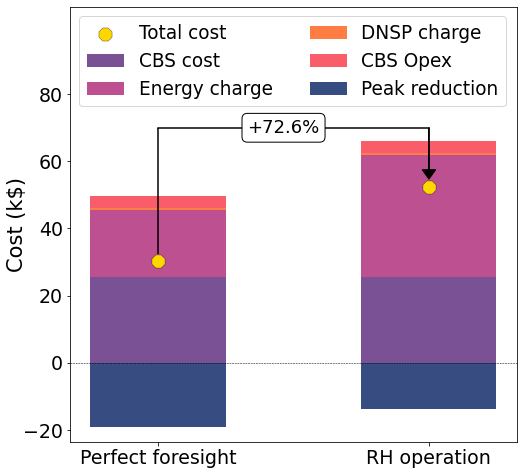

In [26]:
operation_type = ('Perfect foresight', 'RH operation')
cost_counts = {
    'CBS cost': np.array([perfect_foresight_battery_cost, rho_battery_cost]),
    'Energy charge': np.array([perfect_foresight_grid_payment, rho_grid_payment]),
    'DNSP charge': np.array([perfect_foresight_luos, rho_luos]),
    'CBS Opex': np.array([perfect_foresight_battery_opex, rho_battery_opex])
}
width = 0.5  # the width of the bars: can also be len(x) sequence

colour_list = ['#7a5195', '#bc5090', '#ff7c43', '#f95d6a', '#374c80']
lengend_fontsize = 18.5
tick_fontsize = 19
label_fontsize = 21

fig, ax = plt.subplots(figsize=(8, 8))
bottom = np.zeros(2)

for cost, cost_count in cost_counts.items():
    p = ax.bar(operation_type, cost_count, width, label=cost, bottom=bottom, color=colour_list.pop(0))
    bottom += cost_count

ax.bar(operation_type, [perfect_foresight_peak_reduction, rho_peak_reduction], width, label='Peak reduction', bottom=np.zeros(2), color=colour_list.pop(0))
ax.scatter(operation_type, [perfect_foresight_total_cost, rho_total_cost], color='gold', linewidth=0.3, edgecolor='black', s=200, marker='8', label='Total cost')
ax.tick_params(axis='x', labelsize = tick_fontsize)
ax.tick_params(axis='y', labelsize = tick_fontsize)
ax.set_yticks(np.arange(-20, 100, 20))
ax.set_ylim(top=106)
ax.set_ylabel('Cost (k$)', fontsize = label_fontsize, labelpad=-4)

loss = np.around((rho_total_cost - perfect_foresight_total_cost) / perfect_foresight_total_cost * 100, 1)

plt.vlines(x = 0.0009, ymin = 1.07*perfect_foresight_total_cost, ymax = 70, colors = 'black')
plt.axhline(y = 70, xmin = 0.196, xmax = 0.803, color='black')
plt.arrow(1.001, 70, 0, -15.3, head_width=0.05, head_length=2.8, length_includes_head=True, color='black')
ax.annotate(
    f'+{loss}%',
    xy=(0.33, 68.5), xycoords='data',
    xytext=(0, 0), textcoords='offset points', fontsize=18,
    bbox=dict(boxstyle="round", fc="1"))

ax.legend(fontsize=lengend_fontsize, loc=2, ncol=2)

# Draw a line at 0
plt.axhline(y=0, color='black', linewidth=0.5, ls='--')

plt.show()